In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
            
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            dIsample= self.get_random_from_samples()

            #dI = torch.rand(self._n, requires_grad=True).to(device) < dI 
            
            #random will effect the result, less than operation will lose gradient

            activeM= torch.nn.Sigmoid()

            dI= activeM(1000*(dI-dIsample))

            I = torch.max(I, dI) # got infected

            states[self._states_names['I']] = I
        return states
    def get_random_from_samples(self):
        return self._samples[self._t-1]

ModuleNotFoundError: No module named 'epifit'

In [2]:
def sim(time_horizon, population, model):
  log = [population['I']]
  for i in range(time_horizon):
    population = model(population)
    log.append(population['I'])  
  log = torch.stack(log)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log

In [3]:
n = 200 # population
avgDegree = 10  #every individual will have 10 contacts on average
pinf = 0.2  #it is the first parameter we are going to fit
time_horizon = 20

#create  dense contacts
contacts = generate_random_network(n, avgDegree)
contacts = contacts.coalesce()#make pairs unique
print(contacts.values().sum())
contacts = contacts.to_dense()
contacts = contacts.requires_grad_(True)
#random to be used
dIsamples=[]
for _ in range(time_horizon):
    dIsamples.append(torch.rand(n).to(device))
#si true 
si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness",
                  samples=dIsamples, device=device)
#si fit
si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness",
                  samples=dIsamples, device=device)
#deinfe loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.RMSprop(si_fit.parameters(), lr=2e-3)
#generate real data
si_result= None
with torch.no_grad():
    population = Population(n, device=device)
    si_result = sim(time_horizon,population,si)
si_result.requires_grad_(True)
stats_gt   = si_result.sum(dim=3) # si along 20 iterations

tensor(20000., device='cuda:0')


0   0.05000000074505806
1   0.07000000029802322
2   0.08897610753774643
3   0.1014239639043808
4   0.11239834129810333
5   0.11916255950927734
6   0.12885074317455292
7   0.1324840933084488
8   0.13894066214561462
9   0.14346426725387573
10   0.14581671357154846
11   0.14874866604804993
12   0.15267731249332428
13   0.1582568734884262
14   0.15987960994243622
15   0.16175442934036255
16   0.1641804426908493
17   0.16518950462341309
18   0.18240997195243835
19   0.18283255398273468
20   0.18320371210575104
21   0.18365903198719025
22   0.1840384602546692
23   0.18433532118797302
24   0.18461449444293976
25   0.1848953813314438
26   0.18536746501922607
27   0.18590909242630005
28   0.18620826303958893
29   0.18657028675079346
30   0.1872205287218094
31   0.18740037083625793
32   0.18758319318294525
33   0.187771737575531
34   0.18798625469207764
35   0.18839789927005768
36   0.1886458396911621
37   0.18952269852161407
38   0.18982253968715668
39   0.19017548859119415
40   0.1908211857080

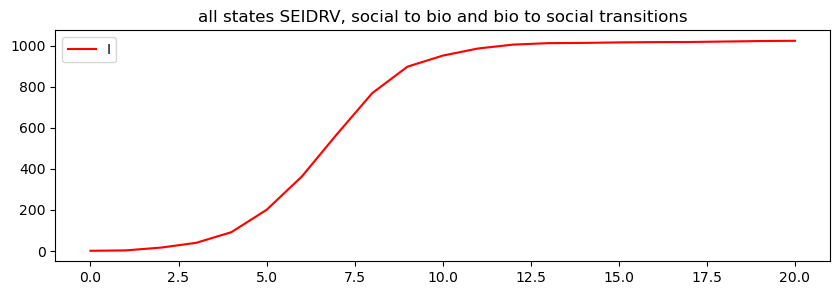

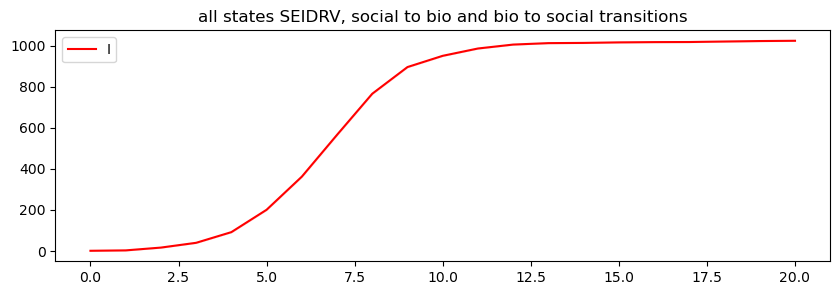

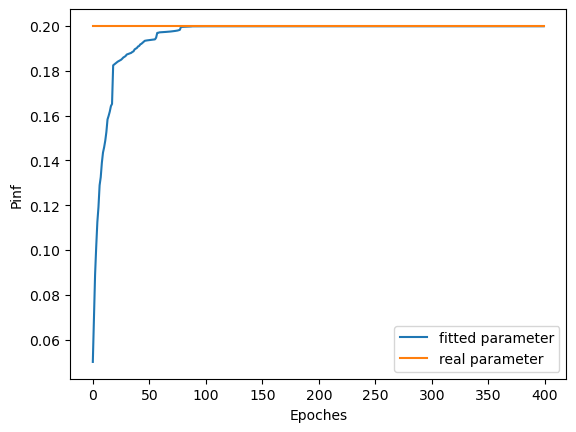

In [4]:
fitPinfs=[]
#gradient direction: negative-> positive
for i in range(400):
    print(i, " ", si_fit._pinf.item())
    optimizer.zero_grad()
    fitPinfs.append(si_fit._pinf.item())
    si_fit._t=0
    population = Population(n, device=device)
    si_pred = sim(time_horizon, population, si_fit)
    stats_pred = si_pred.sum(dim=3)
    loss = loss_fn(stats_gt, stats_pred)
    loss.backward(retain_graph=True)
    optimizer.step()

print_model_parameters(si_fit)
colors = [("red", 'I')]
age_sizes = [n]
plot(si_pred.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plt.plot(fitPinfs, label='fitted parameter')
plt.plot([pinf]*len(fitPinfs), label='real parameter')
plt.xlabel("Epoches")
plt.ylabel("Pinf")
plt.legend()
